In [1]:
# Default methods
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [2]:
# Create Tables for normalization

conn = create_connection('normalized.db')
cur = conn.cursor()
cur.executescript(""" 
    DROP TABLE IF EXISTS SAMPLE;
    DROP TABLE IF EXISTS CUSTOMERS;
    DROP TABLE IF EXISTS INVOICE;
    DROP TABLE IF EXISTS PRODUCT;

    PRAGMA foreign_keys = ON;

    CREATE TABLE SAMPLE (
    [InvoiceNo] TEXT,
    [StockCode] TEXT,
    [Description] TEXT,
    [Quantity] INTEGER,
    [InvoiceDate] Date,
    [UnitPrice] INTEGER,
    [CustomerID] INTEGER,
    [Country] TEXT
    );

    CREATE TABLE CUSTOMERS (
    [CustomerID] INTEGER NOT NULL PRIMARY KEY,
    [Country] TEXT
    );

    CREATE TABLE PRODUCT (
    [StockCode] TEXT NOT NULL PRIMARY KEY,
    [DESCRIPTION] TEXT NOT NULL,
    [UnitPrice] INTEGER
    );

    CREATE TABLE INVOICE (
    [InvoiceNo] INTEGER NOT NULL,
    [InvoiceDate] DATE NOT NULL,
    [CustomerID] INTEGER NOT NULL,
    [StockCode] TEXT NOT NULL,
    [Quantity] INTEGER,
    FOREIGN KEY (CustomerID) REFERENCES CUSTOMERS(CustomerID),
    FOREIGN KEY (StockCode) REFERENCES PRODUCT(StockCode)
    );


""")


In [3]:
#Load CSV Data

with open('data.csv', 'r') as file :
    res = []
    data = []
    i=1
    cur.execute("DELETE FROM SAMPLE;")
    for line in file:
        if not line.strip() :
            continue
        line = line.strip()
        data = line.split(',')
        if i > 1:
            cur.execute("INSERT INTO SAMPLE (InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country) VALUES (?, ?, ?, ?, ?, ?, ?, ?)",(data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]))
        i = i + 1


In [4]:
#Data cleanup

# Remove negative values from Quantity and UnitPrice
sql_update_statement = "update sample set UnitPrice='0' where UnitPrice < '0';"
execute_sql_statement(sql_update_statement, conn)
sql_delete_statement = "delete from sample where Quantity < '0';"
execute_sql_statement(sql_delete_statement, conn)

# Remove C values from InvoiceNo
sql_update_statement = "UPDATE sample SET InvoiceNo = REPLACE(InvoiceNo, 'C', '');"
execute_sql_statement(sql_update_statement, conn)

# Remove blanks from CustomerID
sql_delete_statement = "delete from sample where CustomerID= '' or InvoiceNo='InvoiceNo';"
execute_sql_statement(sql_delete_statement, conn)


# sql_SELECT_statement = "select * from sample;"
# execute_sql_statement(sql_SELECT_statement, conn)
# df = pd.read_sql_query(sql_SELECT_statement, conn)
# display(df)


[]

In [5]:
# Data normalization

cust = []
prod = []
cur = conn.cursor()
cur.execute("select * from SAMPLE;")
original_table = cur.fetchall()
execute_sql_statement("PRAGMA foreign_keys = ON;",conn)

for InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country in original_table:
    if CustomerID not in cust:
        cust.append(CustomerID)
        cur.execute("INSERT INTO CUSTOMERS (CustomerID, Country) VALUES (?, ?)",(CustomerID, Country))


for InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country in original_table:
    if StockCode not in prod:
        prod.append(StockCode)
        cur.execute("INSERT INTO PRODUCT (StockCode, Description, UnitPrice) VALUES (?, ?, ?)",(StockCode, Description, UnitPrice))

for InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country in original_table:
    #print(StockCode)
    cur.execute("INSERT INTO INVOICE (InvoiceNo, InvoiceDate, CustomerID, StockCode, Quantity) VALUES (?, ?, ?, ?, ?)",(InvoiceNo, InvoiceDate, CustomerID, StockCode, Quantity))
    

In [7]:
sql_SELECT_statement = "SELECT * FROM CUSTOMERS;"
#execute_sql_statement(sql_SELECT_statement, conn)
df = pd.read_sql_query(sql_SELECT_statement, conn)
display(df)

,CustomerID,Country
0,12346,United Kingdom
1,12347,Iceland
2,12348,Finland
3,12349,Italy
4,12350,Norway
...,...,...
4334,18280,United Kingdom
4335,18281,United Kingdom
4336,18282,United Kingdom
4337,18283,United Kingdom


In [8]:
# Create dataframe of normalized data

sql_SELECT_statement = """SELECT i.*, p.Description, p.UnitPrice, c.Country from INVOICE As i
INNER JOIN PRODUCT As p ON i.StockCode = p.StockCode
INNER JOIN CUSTOMERS As c ON i.CustomerID = c.CustomerID;"""
#execute_sql_statement(sql_SELECT_statement, conn)
df = pd.read_sql_query(sql_SELECT_statement, conn)
display(df)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Quantity,DESCRIPTION,UnitPrice,Country
0,536365,12/1/2019,17850,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
1,536365,12/1/2019,17850,71053,6,WHITE METAL LANTERN,3.39,United Kingdom
2,536365,12/1/2019,17850,84406B,8,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom
3,536365,12/1/2019,17850,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom
4,536365,12/1/2019,17850,84029E,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom
...,...,...,...,...,...,...,...,...
397919,581587,12/9/2020,12680,22613,12,PACK OF 20 SPACEBOY NAPKINS,0.85,France
397920,581587,12/9/2020,12680,22899,6,CHILDREN'S APRON DOLLY GIRL,2.10,France
397921,581587,12/9/2020,12680,23254,4,CHILDRENS CUTLERY DOLLY GIRL,4.15,France
397922,581587,12/9/2020,12680,23255,4,CHILDRENS CUTLERY CIRCUS PARADE,4.15,France


In [8]:
display(df)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Quantity,DESCRIPTION,UnitPrice,Country
0,536365,12/1/2019,17850,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
1,536365,12/1/2019,17850,71053,6,WHITE METAL LANTERN,3.39,United Kingdom
2,536365,12/1/2019,17850,84406B,8,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom
3,536365,12/1/2019,17850,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom
4,536365,12/1/2019,17850,84029E,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom
...,...,...,...,...,...,...,...,...
397919,581587,12/9/2020,12680,22613,12,PACK OF 20 SPACEBOY NAPKINS,0.85,France
397920,581587,12/9/2020,12680,22899,6,CHILDREN'S APRON DOLLY GIRL,2.10,France
397921,581587,12/9/2020,12680,23254,4,CHILDRENS CUTLERY DOLLY GIRL,4.15,France
397922,581587,12/9/2020,12680,23255,4,CHILDRENS CUTLERY CIRCUS PARADE,4.15,France


In [9]:
##Five number summary of each continious variable
df.describe()

,InvoiceNo,CustomerID,Quantity,UnitPrice
count,397924.000000,397924.000000,397924.000000,397924.000000
mean,560617.128092,15294.315171,13.021823,2.948979
std,13106.166969,1713.169877,180.420210,4.909495
min,536365.000000,12346.000000,1.000000,0.001000
25%,549234.000000,13969.000000,2.000000,1.250000
50%,561893.000000,15159.000000,6.000000,1.950000
75%,572090.000000,16795.000000,12.000000,3.750000
max,581587.000000,18287.000000,80995.000000,295.000000


In [10]:
##Assign a variable name to the given dataframe
Data=df

In [11]:
##import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
Data.dtypes ##Check the datatype for each variable

InvoiceNo        int64
InvoiceDate     object
CustomerID       int64
StockCode       object
Quantity         int64
DESCRIPTION     object
UnitPrice      float64
Country         object
dtype: object

In [13]:
Data.head(15)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Quantity,DESCRIPTION,UnitPrice,Country
0,536365,12/1/2019,17850,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
1,536365,12/1/2019,17850,71053,6,WHITE METAL LANTERN,3.39,United Kingdom
2,536365,12/1/2019,17850,84406B,8,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom
3,536365,12/1/2019,17850,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom
4,536365,12/1/2019,17850,84029E,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom
5,536365,12/1/2019,17850,22752,2,SET 7 BABUSHKA NESTING BOXES,7.65,United Kingdom
6,536365,12/1/2019,17850,21730,6,GLASS STAR FROSTED T-LIGHT HOLDER,4.25,United Kingdom
7,536366,12/1/2019,17850,22633,6,HAND WARMER UNION JACK,1.85,United Kingdom
8,536366,12/1/2019,17850,22632,6,HAND WARMER RED POLKA DOT,1.85,United Kingdom
9,536367,12/1/2019,13047,84879,32,ASSORTED COLOUR BIRD ORNAMENT,1.69,United Kingdom


In [14]:
Data.describe() ## summary for the given data frame  across different statistical parameters

,InvoiceNo,CustomerID,Quantity,UnitPrice
count,397924.000000,397924.000000,397924.000000,397924.000000
mean,560617.128092,15294.315171,13.021823,2.948979
std,13106.166969,1713.169877,180.420210,4.909495
min,536365.000000,12346.000000,1.000000,0.001000
25%,549234.000000,13969.000000,2.000000,1.250000
50%,561893.000000,15159.000000,6.000000,1.950000
75%,572090.000000,16795.000000,12.000000,3.750000
max,581587.000000,18287.000000,80995.000000,295.000000


In [15]:
##Creating a column in the dataframe "Total Price" that is the product of the quantity & unitprice
Data["Total Price"]=Data["Quantity"]*Data["UnitPrice"]
Data.head(15)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Quantity,DESCRIPTION,UnitPrice,Country,Total Price
0,536365,12/1/2019,17850,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom,15.30
1,536365,12/1/2019,17850,71053,6,WHITE METAL LANTERN,3.39,United Kingdom,20.34
2,536365,12/1/2019,17850,84406B,8,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom,22.00
3,536365,12/1/2019,17850,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom,20.34
4,536365,12/1/2019,17850,84029E,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom,20.34
5,536365,12/1/2019,17850,22752,2,SET 7 BABUSHKA NESTING BOXES,7.65,United Kingdom,15.30
6,536365,12/1/2019,17850,21730,6,GLASS STAR FROSTED T-LIGHT HOLDER,4.25,United Kingdom,25.50
7,536366,12/1/2019,17850,22633,6,HAND WARMER UNION JACK,1.85,United Kingdom,11.10
8,536366,12/1/2019,17850,22632,6,HAND WARMER RED POLKA DOT,1.85,United Kingdom,11.10
9,536367,12/1/2019,13047,84879,32,ASSORTED COLOUR BIRD ORNAMENT,1.69,United Kingdom,54.08


In [16]:
Data.describe()

,InvoiceNo,CustomerID,Quantity,UnitPrice,Total Price
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,560617.128092,15294.315171,13.021823,2.948979,24.087583
std,13106.166969,1713.169877,180.420210,4.909495,305.928889
min,536365.000000,12346.000000,1.000000,0.001000,0.001000
25%,549234.000000,13969.000000,2.000000,1.250000,4.950000
50%,561893.000000,15159.000000,6.000000,1.950000,12.450000
75%,572090.000000,16795.000000,12.000000,3.750000,19.800000
max,581587.000000,18287.000000,80995.000000,295.000000,168469.600000


In [17]:
Data.shape  ##TO check the dimensions of the dataset

(397924, 9)

In [18]:
## to check the minimum invoice date
Data['InvoiceDate'].min()

'1/10/2020'

In [19]:
##To check the last date available in our dataset
Data['InvoiceDate'].max() 

'9/9/2020'

In [20]:

## To import date 
import datetime as dt

In [21]:
## Here we created a latest date/current date variable using the basic datetime library
date_current = dt.date(2020,9,9)
print(date_current)




2020-09-09


In [22]:
##Recency 
#(1)we need to create a temporary new column that will give us the invoice date only
Data['New_InvoiceDate'] = pd.DatetimeIndex(Data['InvoiceDate']).date

In [23]:
Data.head(10)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Quantity,DESCRIPTION,UnitPrice,Country,Total Price,New_InvoiceDate
0,536365,12/1/2019,17850,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom,15.30,2019-12-01
1,536365,12/1/2019,17850,71053,6,WHITE METAL LANTERN,3.39,United Kingdom,20.34,2019-12-01
2,536365,12/1/2019,17850,84406B,8,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom,22.00,2019-12-01
3,536365,12/1/2019,17850,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom,20.34,2019-12-01
4,536365,12/1/2019,17850,84029E,6,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom,20.34,2019-12-01
5,536365,12/1/2019,17850,22752,2,SET 7 BABUSHKA NESTING BOXES,7.65,United Kingdom,15.30,2019-12-01
6,536365,12/1/2019,17850,21730,6,GLASS STAR FROSTED T-LIGHT HOLDER,4.25,United Kingdom,25.50,2019-12-01
7,536366,12/1/2019,17850,22633,6,HAND WARMER UNION JACK,1.85,United Kingdom,11.10,2019-12-01
8,536366,12/1/2019,17850,22632,6,HAND WARMER RED POLKA DOT,1.85,United Kingdom,11.10,2019-12-01
9,536367,12/1/2019,13047,84879,32,ASSORTED COLOUR BIRD ORNAMENT,1.69,United Kingdom,54.08,2019-12-01


In [24]:
##Creating a recency dataframe ,here we grouped the invoice date on cutomer ID

Recency_df = Data.groupby(by='CustomerID', as_index=False)['New_InvoiceDate'].max()
Recency_df.columns = ['CustomerID','Recent_purchase_date']
Recency_df.head(10)

,CustomerID,Recent_purchase_date
0,12346,2020-01-18
1,12347,2020-12-07
2,12348,2020-09-25
3,12349,2020-11-21
4,12350,2020-02-02
5,12352,2020-11-03
6,12353,2020-05-19
7,12354,2020-04-21
8,12355,2020-05-09
9,12356,2020-11-17


In [25]:
##For recency 
##To calculate the recency

Recency_df['Recency']=Recency_df['Recent_purchase_date'].apply(lambda x: (date_current - x).days)

In [26]:
display(Recency_df)

,CustomerID,Recent_purchase_date,Recency
0,12346,2020-01-18,235
1,12347,2020-12-07,-89
2,12348,2020-09-25,-16
3,12349,2020-11-21,-73
4,12350,2020-02-02,220
...,...,...,...
4334,18280,2020-03-07,186
4335,18281,2020-06-12,89
4336,18282,2020-12-02,-84
4337,18283,2020-12-06,-88


In [27]:
#print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", Data['InvoiceNo'].nunique())
print("Number of products bought: ",Data['StockCode'].nunique())
print("Number of customers:", Data['CustomerID'].nunique() )
##print("Percentage of customers NA: ", round(Data['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Number of transactions:  18536
Number of products bought:  3665
Number of customers: 4339


In [28]:
##Frequency , this parameter will help us to undertsand the multitime and single time customer
# drop duplicates
Data_copy = Data
Data_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = Data_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()
frequency_df.shape


(4339, 2)

In [29]:
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [30]:
##Monetary Value , Sale provided by each and every customer
monetary_df = Data.groupby(by='CustomerID',as_index=False).agg({'Total Price':'sum'})
monetary_df.columns=['CustomerID','Monetary']
monetary_df.head()



,CustomerID,Monetary
0,12346,77183.60
1,12347,208.04
2,12348,331.36
3,12349,15.00
4,12350,25.20


In [31]:
##Creating RFM Score ,by creating RFM table. RFM score will give us an idea to segment customers on 3 parameters (Recency,Frequency ,Monetary)

##Merging alll the New Dataframes to the orignal Data Frame 
## Merging Recency df on Frequency df


df_1=Recency_df.merge(frequency_df,on='CustomerID')
df_1.head()


,CustomerID,Recent_purchase_date,Recency,Frequency
0,12346,2020-01-18,235,1
1,12347,2020-12-07,-89,7
2,12348,2020-09-25,-16,4
3,12349,2020-11-21,-73,1
4,12350,2020-02-02,220,1


In [32]:
##Merging monetary df with the above data frame
df_2=df_1.merge(monetary_df,on='CustomerID')
df_2.head(100)



,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary
0,12346,2020-01-18,235,1,77183.60
1,12347,2020-12-07,-89,7,208.04
2,12348,2020-09-25,-16,4,331.36
3,12349,2020-11-21,-73,1,15.00
4,12350,2020-02-02,220,1,25.20
...,...,...,...,...,...
95,12462,2020-11-21,-73,2,21.14
96,12463,2020-10-17,-38,4,82.46
97,12464,2020-11-29,-81,8,286.40
98,12465,2020-11-22,-74,2,22.68


In [33]:
##Creating a RFM dataframe from the merged data frame
## This dataframe consists of  Recency Frequency Monetary columns

rfm=df_2
rfm

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary
0,12346,2020-01-18,235,1,77183.60
1,12347,2020-12-07,-89,7,208.04
2,12348,2020-09-25,-16,4,331.36
3,12349,2020-11-21,-73,1,15.00
4,12350,2020-02-02,220,1,25.20
...,...,...,...,...,...
4334,18280,2020-03-07,186,1,19.35
4335,18281,2020-06-12,89,1,5.04
4336,18282,2020-12-02,-84,2,34.65
4337,18283,2020-12-06,-88,16,63.40


In [34]:
##Reseting the index of the RFM dataframe
rfm = rfm.reset_index(drop=True)

In [35]:

rfm.head(22)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary
0,12346,2020-01-18,235,1,77183.60
1,12347,2020-12-07,-89,7,208.04
2,12348,2020-09-25,-16,4,331.36
3,12349,2020-11-21,-73,1,15.00
4,12350,2020-02-02,220,1,25.20
5,12352,2020-11-03,-55,8,117.05
6,12353,2020-05-19,113,1,19.90
7,12354,2020-04-21,141,1,20.80
8,12355,2020-05-09,123,1,30.00
9,12356,2020-11-17,-69,3,167.10


In [36]:
display(rfm)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary
0,12346,2020-01-18,235,1,77183.60
1,12347,2020-12-07,-89,7,208.04
2,12348,2020-09-25,-16,4,331.36
3,12349,2020-11-21,-73,1,15.00
4,12350,2020-02-02,220,1,25.20
...,...,...,...,...,...
4334,18280,2020-03-07,186,1,19.35
4335,18281,2020-06-12,89,1,5.04
4336,18282,2020-12-02,-84,2,34.65
4337,18283,2020-12-06,-88,16,63.40


In [37]:
## Creating Quantiles for the RFM 

quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,CustomerID,Recency,Frequency,Monetary
0.25,13812.5,-74.0,1.0,17.850
0.50,15299.0,-41.0,2.0,48.870
0.75,16778.5,50.5,5.0,137.975


In [38]:
quantiles.to_dict()

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'Recency': {0.25: -74.0, 0.5: -41.0, 0.75: 50.5},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.85, 0.5: 48.870000000000005, 0.75: 137.975}}

##

In [39]:
##Arguments (x = value, b = recency, monetary_value, frequency, d = quartiles dict) 
## Creating a RFM score bucket by using the quantile scores

def RScore(a,b,c):
    if a <= c[b][0.25]:
        return 4
    elif a <= c[b][0.50]:
        return 3
    elif a <= c[b][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, b = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4

In [40]:
## Defining R quartile, F_Quartile, M_Quartile
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [41]:
display(rfm_segmentation)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
0,12346,2020-01-18,235,1,77183.60,1,1,4
1,12347,2020-12-07,-89,7,208.04,4,4,4
2,12348,2020-09-25,-16,4,331.36,2,3,4
3,12349,2020-11-21,-73,1,15.00,3,1,1
4,12350,2020-02-02,220,1,25.20,1,1,2
...,...,...,...,...,...,...,...,...
4334,18280,2020-03-07,186,1,19.35,1,1,2
4335,18281,2020-06-12,89,1,5.04,1,1,1
4336,18282,2020-12-02,-84,2,34.65,4,2,2
4337,18283,2020-12-06,-88,16,63.40,4,4,3


In [42]:
##Compiling all the segments together 

rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346,2020-01-18,235,1,77183.60,1,1,4,114
1,12347,2020-12-07,-89,7,208.04,4,4,4,444
2,12348,2020-09-25,-16,4,331.36,2,3,4,234
3,12349,2020-11-21,-73,1,15.00,3,1,1,311
4,12350,2020-02-02,220,1,25.20,1,1,2,112


In [43]:
rfm_segmentation['Frequency'].mean()

4.271952062687255

In [44]:
rfm_segmentation['Frequency'].describe()

count    4339.000000
mean        4.271952
std         7.705493
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: Frequency, dtype: float64

Creating ,  Target Variable as "Frequency Classifier" , we divided the frequency variable into two sections on the basis of mean.
The less frequent customers were below the mean, whereas more frequent customers were above the mean..
Mean of the Frequency Variable : 4

In [45]:

tmp = []
for freq in rfm_segmentation["Frequency"]:
    if freq < 4:
        tmp.append(0)
    else:
        tmp.append(1)
rfm_segmentation['Frequency_classifier'] = tmp

display(rfm_segmentation)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier
0,12346,2020-01-18,235,1,77183.60,1,1,4,114,0
1,12347,2020-12-07,-89,7,208.04,4,4,4,444,1
2,12348,2020-09-25,-16,4,331.36,2,3,4,234,1
3,12349,2020-11-21,-73,1,15.00,3,1,1,311,0
4,12350,2020-02-02,220,1,25.20,1,1,2,112,0
...,...,...,...,...,...,...,...,...,...,...
4334,18280,2020-03-07,186,1,19.35,1,1,2,112,0
4335,18281,2020-06-12,89,1,5.04,1,1,1,111,0
4336,18282,2020-12-02,-84,2,34.65,4,2,2,422,0
4337,18283,2020-12-06,-88,16,63.40,4,4,3,443,1


In [46]:
import seaborn as sns

C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Recency'>

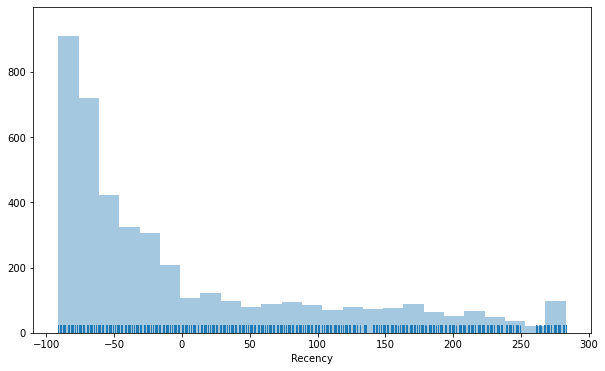

In [47]:
## Plot Recency 


plt.figure(figsize=(10,6))
sns.distplot(rfm_segmentation.Recency,kde=False,rug=True)

C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency'>

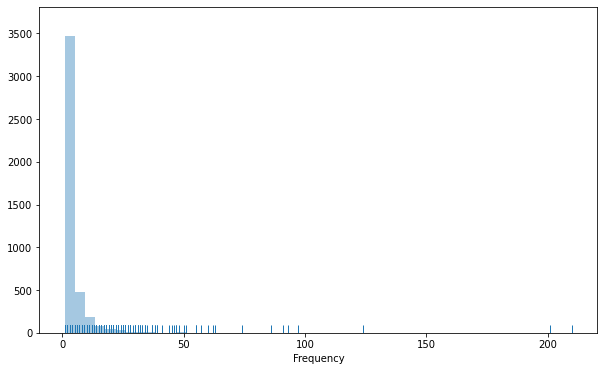

In [48]:
##Plot Frequency 

plt.figure(figsize=(10,6))
sns.distplot(rfm_segmentation.Frequency,kde=False,rug=True)

C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Days since last purchase')

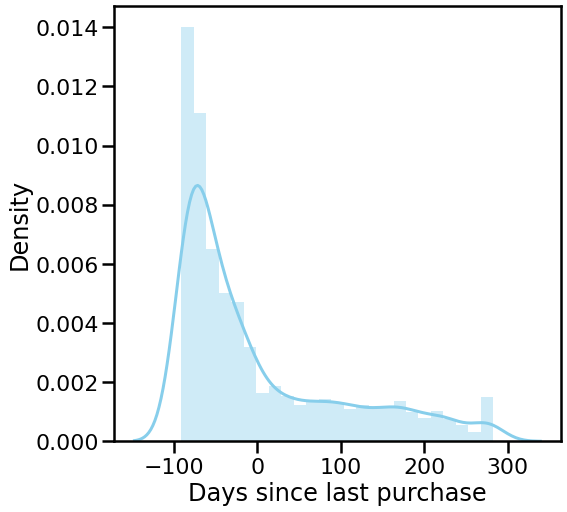

In [49]:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['skyblue'])
sns.distplot(rfm_segmentation['Recency'])
plt.xlabel('Days since last purchase')

C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

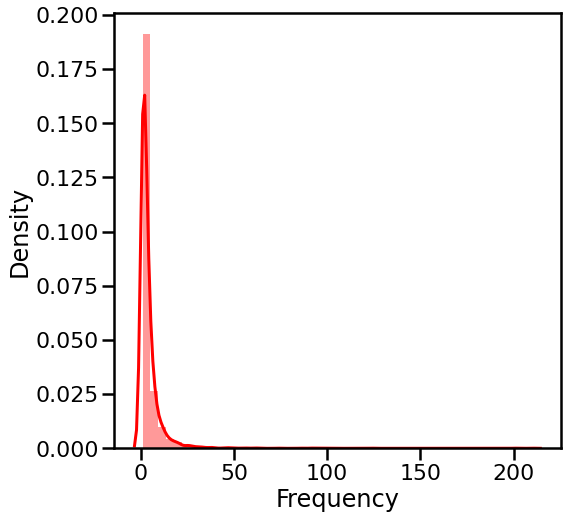

In [50]:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['red'])
sns.distplot(rfm_segmentation['Frequency'])

In [51]:
##Using the KMeans Algorithm to find the cluster of customers with high average monetary value and are highly frequent.
##Using the clustering analysis we will be able to segment the customers based on their frequency and monetary value

In [52]:
from sklearn.cluster import KMeans

In [53]:
rfm_segmentation.dtypes

CustomerID                int64
Recent_purchase_date     object
Recency                   int64
Frequency                 int64
Monetary                float64
R_Quartile                int64
F_Quartile                int64
M_Quartile                int64
RFMScore                 object
Frequency_classifier      int64
dtype: object

In [54]:
rfm_segmentation['Monetary'].astype(int)

0       77183
1         208
2         331
3          15
4          25
        ...  
4334       19
4335        5
4336       34
4337       63
4338       77
Name: Monetary, Length: 4339, dtype: int32

In [55]:
rfm_segmentation.dtypes

CustomerID                int64
Recent_purchase_date     object
Recency                   int64
Frequency                 int64
Monetary                float64
R_Quartile                int64
F_Quartile                int64
M_Quartile                int64
RFMScore                 object
Frequency_classifier      int64
dtype: object

In [56]:
display(rfm_segmentation)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier
0,12346,2020-01-18,235,1,77183.60,1,1,4,114,0
1,12347,2020-12-07,-89,7,208.04,4,4,4,444,1
2,12348,2020-09-25,-16,4,331.36,2,3,4,234,1
3,12349,2020-11-21,-73,1,15.00,3,1,1,311,0
4,12350,2020-02-02,220,1,25.20,1,1,2,112,0
...,...,...,...,...,...,...,...,...,...,...
4334,18280,2020-03-07,186,1,19.35,1,1,2,112,0
4335,18281,2020-06-12,89,1,5.04,1,1,1,111,0
4336,18282,2020-12-02,-84,2,34.65,4,2,2,422,0
4337,18283,2020-12-06,-88,16,63.40,4,4,3,443,1


In [57]:
rfm_segmentation.dtypes

CustomerID                int64
Recent_purchase_date     object
Recency                   int64
Frequency                 int64
Monetary                float64
R_Quartile                int64
F_Quartile                int64
M_Quartile                int64
RFMScore                 object
Frequency_classifier      int64
dtype: object

In [58]:
rfm_segmentation['Monetary'].astype('int')

0       77183
1         208
2         331
3          15
4          25
        ...  
4334       19
4335        5
4336       34
4337       63
4338       77
Name: Monetary, Length: 4339, dtype: int32

In [59]:
##Checking the datatypes of the different columns
rfm_segmentation.dtypes

CustomerID                int64
Recent_purchase_date     object
Recency                   int64
Frequency                 int64
Monetary                float64
R_Quartile                int64
F_Quartile                int64
M_Quartile                int64
RFMScore                 object
Frequency_classifier      int64
dtype: object

In [60]:
##Converting thE Target Variable into a Category
rfm_segmentation['Frequency_classifier'].astype('category')

0       0
1       1
2       1
3       0
4       0
       ..
4334    0
4335    0
4336    0
4337    1
4338    0
Name: Frequency_classifier, Length: 4339, dtype: category
Categories (2, int64): [0, 1]

In [61]:
##Creating Year and Month Variables for the analysis

dt = rfm_segmentation.Recent_purchase_date
(dt.iloc[1]).day
dict1={"Year":[],"Month":[]}
for i in range(len(dt)):
    dict1["Year"].append(int((dt.iloc[i]).year))
    dict1["Month"].append(int((dt.iloc[i]).month))

In [62]:
df1 = pd.DataFrame(dict1)

In [63]:
print(len(df1),len(rfm_segmentation))

4339 4339


In [64]:
result = pd.concat([rfm_segmentation.reset_index(drop=True),df1.reset_index(drop=True)],axis=1)

In [65]:
result.head(100)

,CustomerID,Recent_purchase_date,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier,Year,Month
0,12346,2020-01-18,235,1,77183.60,1,1,4,114,0,2020,1
1,12347,2020-12-07,-89,7,208.04,4,4,4,444,1,2020,12
2,12348,2020-09-25,-16,4,331.36,2,3,4,234,1,2020,9
3,12349,2020-11-21,-73,1,15.00,3,1,1,311,0,2020,11
4,12350,2020-02-02,220,1,25.20,1,1,2,112,0,2020,2
...,...,...,...,...,...,...,...,...,...,...,...,...
95,12462,2020-11-21,-73,2,21.14,3,2,2,322,0,2020,11
96,12463,2020-10-17,-38,4,82.46,2,3,3,233,1,2020,10
97,12464,2020-11-29,-81,8,286.40,4,4,4,444,1,2020,11
98,12465,2020-11-22,-74,2,22.68,4,2,2,422,0,2020,11


In [66]:
RFM_Final = result.drop(['Recent_purchase_date'],axis=1)

In [67]:
##RFM Final Data frame consists of , Customer ID, Recency, Frequency, Monetary, R_Quartile, F_Quartile, Frequency Classifier, Year, Month

RFM_Final.describe()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,Frequency_classifier,Year,Month
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,1.115695,4.271952,307.142685,2.506107,2.319889,2.496889,0.346163,2019.972574,9.107168
std,1721.889758,100.185303,7.705493,3153.022855,1.122159,1.143869,1.120733,0.475801,0.163339,2.974812
min,12346.000000,-91.000000,1.000000,0.420000,1.000000,1.000000,1.000000,0.000000,2019.000000,1.000000
25%,13812.500000,-74.000000,1.000000,17.850000,1.500000,1.000000,1.000000,0.000000,2020.000000,8.000000
50%,15299.000000,-41.000000,2.000000,48.870000,3.000000,2.000000,2.000000,0.000000,2020.000000,10.000000
75%,16778.500000,50.500000,5.000000,137.975000,4.000000,3.000000,3.500000,1.000000,2020.000000,11.000000
max,18287.000000,283.000000,210.000000,168471.250000,4.000000,4.000000,4.000000,1.000000,2020.000000,12.000000


In [68]:
RFM_Final.dtypes

CustomerID                int64
Recency                   int64
Frequency                 int64
Monetary                float64
R_Quartile                int64
F_Quartile                int64
M_Quartile                int64
RFMScore                 object
Frequency_classifier      int64
Year                      int64
Month                     int64
dtype: object

In [69]:
RFM_Final['Frequency_classifier'].astype('category')

0       0
1       1
2       1
3       0
4       0
       ..
4334    0
4335    0
4336    0
4337    1
4338    0
Name: Frequency_classifier, Length: 4339, dtype: category
Categories (2, int64): [0, 1]

In [70]:
## Creating Clusters for the Different customers with respect to Monetary and Frequency

Segment_1 = KMeans(n_clusters = 4, init = 'k-means++')

nclusters = Segment_1.fit_predict(RFM_Final)

clusters = pd.DataFrame(nclusters, columns = ['clusters'], index = RFM_Final.index)

# Concatenating the clusters with the RFM dataframe:
rfmK= pd.concat([RFM_Final, clusters], axis=1)

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

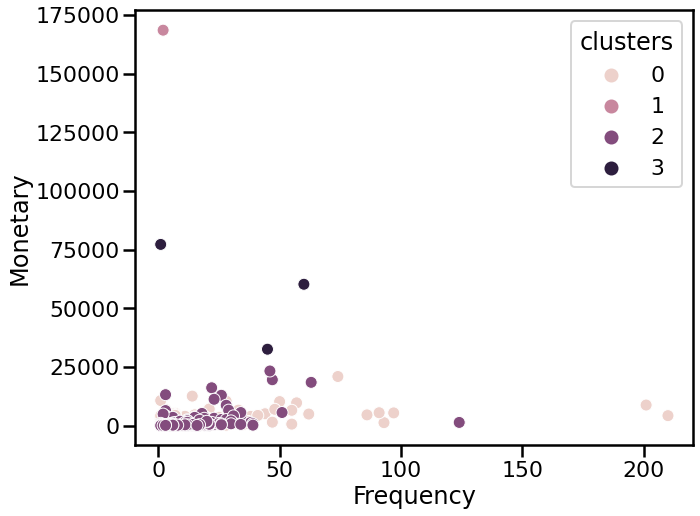

In [71]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = rfmK, x='Frequency', y='Monetary', hue='clusters')

In [72]:
RFM_Seg = rfmK.copy()

RFM_Seg['clusters'] = ['Best Custumers' if x == 3 else x for x in RFM_Seg['clusters']]
RFM_Seg['clusters'] = ['Frequent Customers' if x == 2 else x for x in RFM_Seg['clusters']]
RFM_Seg['clusters'] = ['Usual Customers' if x == 0 else x for x in RFM_Seg['clusters']]
RFM_Seg['clusters'] = ['Thrifters' if x == 1 else x for x in RFM_Seg['clusters']]

In [73]:
display(RFM_Seg)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier,Year,Month,clusters
0,12346,235,1,77183.60,1,1,4,114,0,2020,1,Best Custumers
1,12347,-89,7,208.04,4,4,4,444,1,2020,12,Usual Customers
2,12348,-16,4,331.36,2,3,4,234,1,2020,9,Usual Customers
3,12349,-73,1,15.00,3,1,1,311,0,2020,11,Usual Customers
4,12350,220,1,25.20,1,1,2,112,0,2020,2,Usual Customers
...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,186,1,19.35,1,1,2,112,0,2020,3,Frequent Customers
4335,18281,89,1,5.04,1,1,1,111,0,2020,6,Frequent Customers
4336,18282,-84,2,34.65,4,2,2,422,0,2020,12,Frequent Customers
4337,18283,-88,16,63.40,4,4,3,443,1,2020,12,Frequent Customers


<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

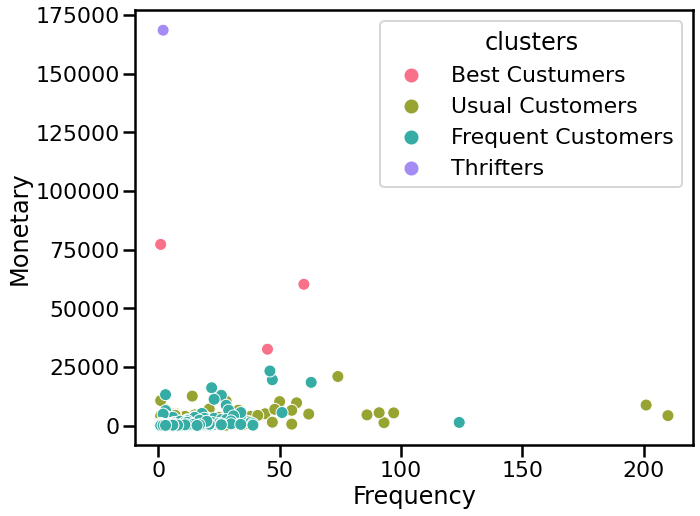

In [74]:
##Creating Clusters , Best Customers, Frequent Customers, Usual Customers, Thriifters


plt.figure(figsize=(10,8))
sns.scatterplot(data = RFM_Seg, x='Frequency', y='Monetary',hue='clusters')

In [75]:
display(RFM_Seg)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier,Year,Month,clusters
0,12346,235,1,77183.60,1,1,4,114,0,2020,1,Best Custumers
1,12347,-89,7,208.04,4,4,4,444,1,2020,12,Usual Customers
2,12348,-16,4,331.36,2,3,4,234,1,2020,9,Usual Customers
3,12349,-73,1,15.00,3,1,1,311,0,2020,11,Usual Customers
4,12350,220,1,25.20,1,1,2,112,0,2020,2,Usual Customers
...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,186,1,19.35,1,1,2,112,0,2020,3,Frequent Customers
4335,18281,89,1,5.04,1,1,1,111,0,2020,6,Frequent Customers
4336,18282,-84,2,34.65,4,2,2,422,0,2020,12,Frequent Customers
4337,18283,-88,16,63.40,4,4,3,443,1,2020,12,Frequent Customers


In [76]:
RFM_Seg['Recency'].min()
RFM_Seg['Recency'].max()

283

In [77]:
RFM_Seg['Monetary'].min()
RFM_Seg['Monetary'].max()
RFM_Seg['Monetary'].describe()

count      4339.000000
mean        307.142685
std        3153.022855
min           0.420000
25%          17.850000
50%          48.870000
75%         137.975000
max      168471.250000
Name: Monetary, dtype: float64

In [78]:
##Final Data frame for the modelling , we will be selecting the variables from the dataframes that we created .
display(RFM_Seg)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier,Year,Month,clusters
0,12346,235,1,77183.60,1,1,4,114,0,2020,1,Best Custumers
1,12347,-89,7,208.04,4,4,4,444,1,2020,12,Usual Customers
2,12348,-16,4,331.36,2,3,4,234,1,2020,9,Usual Customers
3,12349,-73,1,15.00,3,1,1,311,0,2020,11,Usual Customers
4,12350,220,1,25.20,1,1,2,112,0,2020,2,Usual Customers
...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,186,1,19.35,1,1,2,112,0,2020,3,Frequent Customers
4335,18281,89,1,5.04,1,1,1,111,0,2020,6,Frequent Customers
4336,18282,-84,2,34.65,4,2,2,422,0,2020,12,Frequent Customers
4337,18283,-88,16,63.40,4,4,3,443,1,2020,12,Frequent Customers


In [79]:
display(RFM_Seg)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Frequency_classifier,Year,Month,clusters
0,12346,235,1,77183.60,1,1,4,114,0,2020,1,Best Custumers
1,12347,-89,7,208.04,4,4,4,444,1,2020,12,Usual Customers
2,12348,-16,4,331.36,2,3,4,234,1,2020,9,Usual Customers
3,12349,-73,1,15.00,3,1,1,311,0,2020,11,Usual Customers
4,12350,220,1,25.20,1,1,2,112,0,2020,2,Usual Customers
...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,186,1,19.35,1,1,2,112,0,2020,3,Frequent Customers
4335,18281,89,1,5.04,1,1,1,111,0,2020,6,Frequent Customers
4336,18282,-84,2,34.65,4,2,2,422,0,2020,12,Frequent Customers
4337,18283,-88,16,63.40,4,4,3,443,1,2020,12,Frequent Customers


In [80]:
##Creating Train and Test 

from sklearn.model_selection import train_test_split 

In [81]:
RFM_Seg['clusters'].astype('category')

0           Best Custumers
1          Usual Customers
2          Usual Customers
3          Usual Customers
4          Usual Customers
               ...        
4334    Frequent Customers
4335    Frequent Customers
4336    Frequent Customers
4337    Frequent Customers
4338    Frequent Customers
Name: clusters, Length: 4339, dtype: category
Categories (4, object): ['Best Custumers', 'Frequent Customers', 'Thrifters', 'Usual Customers']

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [86]:
#split dataset in features and target variable
## Run again from this step, change the target variable to Frequency_classifier (i executed the model got an accuracy of 100)
feature_columns = ['Recency','Frequency','Monetary','R_Quartile','F_Quartile','M_Quartile','RFMScore','Year','Month']

X = RFM_Seg[feature_columns] # Features
y = RFM_Seg.Frequency_classifier # Target variable

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [88]:
# import the class
##rom sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

C:\Users\tanay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
##Confusion Matrix

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[693,   0],
       [  0, 392]], dtype=int64)

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

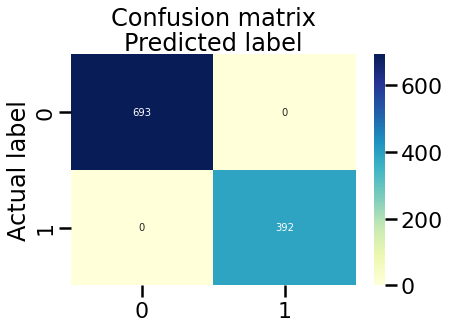

In [91]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [92]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


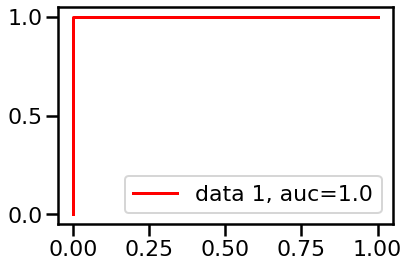

In [93]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()